#Линейные модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

## Логистическая регрессия

_Логистическая регрессия_ - частный случай линейного классификатора, обладающий одной полезной особенностью - помимо отнесения объекта к определенному классу она умеет прогнозировать вероятность $P$ того, что объект относится к этому классу.


Пусть в каждой точке пространства объектов $\mathbb{X}$ задана вероятность того, что объект $x$ будет принадлежать к классу "+1" $P(y=1|x)$ (условная вероятность $y = 1$ при условии $x$). Она будет принимать значения от 0 до 1, и нам нужно каким-то образом ее предсказывать, но пока мы умеем только строить прогноз методами линейной регрессии с помощью некоего алгоритма $b(x)=\left \langle w,x_{i} \right \rangle$. У него есть проблема, связанная с тем, что скалярное произведение $\left \langle w,x_{i} \right \rangle$ не всегда возвращает значения в отрезке [0, 1]. Чтобы достичь такого условия, можно использовать некую функцию $\sigma:\mathbb{R} \rightarrow [0,1]$, которая будет переводить полученное в скалярном произведении значение в вероятность, пределы которой будут лежать в промежутке от 0 до 1. 

### Рабочая часть модели

В модели логистической регрессии в качестве такой функции берется сигмоида, которая имеет вид:

$$z(x_{i})=\left \langle w,x_{i} \right \rangle$$

$$\sigma(z) = \frac{1}{1 + exp(-z)}.$$


### Потери

В случае, когда $y$ принимает значения 0 и 1, log loss запишется как

$$-\text{ln}L(X) = -\sum^{l}_{i=1} (y_{i} \text{ln}\frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)} + (1 - y_{i})\text{ln} \frac{exp(-\left \langle w,x_{i} \right \rangle)}{1 + exp(-\left \langle w,x_{i} \right \rangle)}).$$



$$-\text{ln}L(X) = -\sum^{l}_{i=1} ( y_{i} \text{ln}\ sigma(z_{i}) + (1 - y_{i})\text{ln} ( 1  -  sigma(z_{i}))).$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings( "ignore")

Реализация логистической регрессии :

In [4]:
#
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#
def log_loss(w, X, y):
    m = X.shape[1]
    

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

#
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    X = X.T
    X = np.vstack((np.ones((1,X.shape[1])),X))
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses
#
def predict(w, X):
    X = X.T
    m = X.shape[1]
    X = np.vstack((np.ones((1,X.shape[1])),X))
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= 0.5):
            y_predicted[:, i] = 0
    
    return y_predicted

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

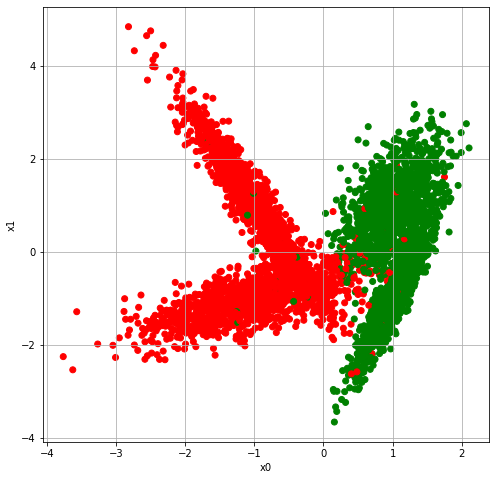

In [6]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=110)
# 

#classes = datasets.make_blobs(n_samples=1000,centers = 2, cluster_std = 1., random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()


In [7]:
# разбиение данных на тренировочные и отложенную выборку (тестовые), 
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[1]+1, 1))+0.1
n_iterations = 500
eta = 0.05

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[-0.25265114]
 [ 2.85147318]
 [ 0.09719725]]
Точность на обучающей выборке: 96.750
Точность на тестовой выборке: 97.800


### **Задание 1.**

1.1 Измените модель логистической регрессии из кода выше на модель с условием выхода по числу итераций (это есть ) и разнице параметров w для двух последовательных шагов.

1.2 Измените модель для сохранения на каждом шаге изменения параметров w ошибки модели в тестовом наборе данных (на отложенной выборке)

1.3 Добавьте собственную реализацию вычисления Accuracy

1.4 Оцените (постройте кривые изменения Accuracy и потерь для тестовой(отложенной выборки) ) поведение модели при использовании одного критерия останова и 2-х (исходная схема модели и модель по п.1.1) 

1.5  зафиксируйте результаты в таблице и сделайте выводы

In [12]:
# разбиение данных на тренировочные и отложенную выборку (тестовые), 
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[1]+1, 1))+11
n_iterations = 500
eta = 0.05

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[ 6.50195002]
 [14.90591469]
 [ 5.92625227]]
Точность на обучающей выборке: 90.800
Точность на тестовой выборке: 92.200


### **Задание 2.**

1.1  Проведите эксперимент(для кода из результата задания 1) с изменением шага обучения eta в диапазоне (0.1, 2) с дискретностью 0.1

1.2  зафиксируйте результаты в таблице и сделайте выводы


## Sklearn LogisticRegression

Классификатор логистической регрессии (также известный как логит, MaxEnt) https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

  - Класс реализует логистическую регрессию с использованием библиотеки «liblinear», решателей «newton-cg», «sag», «saga» и «lbfgs». 

  - Регуляризация применяется по умолчанию (не для всех решателей одинаковая).

  - В случае с несколькими классами алгоритм обучения использует схему «один против остальных» (OvR)


  - penalty {'l1', 'l2', 'elasticnet', 'none'}, по умолчанию = 'l2':

      - 'none': пенальти не добавляется;

      - 'l2': штраф L2 (по умолчанию);

      - 'l1': штраф L1;

      -  'elasticnet': штраф L1 и L2.

  - tol: критерий останова по изменению параметров модели default=1e-4

  - class_weight - dict или ‘balanced’, default=None. Веса, классов для случая разбалансированных данных (большему классу ставим меньший вес) . Если не указано, предполагается, что все классы имеют вес один.{class_label: weight}
. Режим ‘balanced’использует значения y для автоматической корректировки весов обратно пропорционально частотам классов во входных данных как .n_samples / (n_classes * np.bincount(y))

  - solver : решатель {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, по умолчанию = 'lbfgs'. Алгоритм для использования в задаче оптимизации. Значение по умолчанию — 'lbfgs'. Для небольших наборов данных хорошим выбором является «liblinear», «sag» и «saga» работают быстрее для больших.Для многоклассовых задач только «newton-cg», «sag», «saga» и «lbfgs». Выбор алгоритма и штрафа связаны. Поддерживаемые решателем штрафы:

      - ‘newton-cg’ - [‘l2’, ‘none’]
      - ‘lbfgs’ - [‘l2’, ‘none’]
      - ‘liblinear’ - [‘l1’, ‘l2’]
      - ‘sag’ - [‘l2’, ‘none’]
      - ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]


  - max_iter : критерий останова по числу итераций, по умолчанию = 100
Максимальное количество итераций, необходимых для сходимости решателей.

  - multi_class {‘auto’, ‘ovr’, ‘multinomial’}, по умолчанию = ‘auto’. Если выбрана опция 'ovr', то для каждой метки решается бинарная задача. Для ‘multinomial’ минимизация потерь — это ‘multinomial’ потери, подходящие для всего распределения вероятностей, даже если данные являются двоичными . 
  - n_jobs : Количество ядер ЦП, используемых при распараллеливании по классам, если multi_class='ovr'». None означает 1,  -1 означает использование всех процессоров. 

  - l1_ratio параметр регуляризации Elastic-Net для комбинирования L1 и L2.




In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

## SKlearn метрики

Модуль sklearn.metrics предоставляет набор простых функций, измеряющих ошибку предсказания с учетом истинности и предсказания:

  - функции, заканчивающиеся на, _score возвращают значение для максимизации, чем выше, тем лучше.
  - функции, заканчивающиеся на _error или _loss возвращающие значение, которое нужно минимизировать, чем ниже, тем лучше. 
  

Некоторые из них ограничены случаем двоичной классификации:

  - precision_recall_curve(y_true, probas_pred, *)	Вычислите пары точности-полноты для разных пороговых значений вероятности.
  - roc_curve(y_true, y_score, *[, pos_label, …])	Вычислить рабочую характеристику приемника (ROC).

Другие работают в случае мультикласса:

  - balanced_accuracy_score(y_true, y_pred, *[, …])	Вычислите сбалансированную точность.
  - confusion_matrix(y_true, y_pred, *[, …])	Вычислите матрицу неточностей, чтобы оценить точность классификации.
  - roc_auc_score(y_true, y_score, *[, average, …])	Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

Работают универсально:

  - accuracy_score(y_true, y_pred, *[, …])	Классификационная оценка accuracy.
  - classification_report(y_true, y_pred, *[, …])	Создайте текстовый отчет, показывающий основные показатели классификации.
  - f1_score(y_true, y_pred, *[, labels, …])	Вычислите оценку F1, также известную как сбалансированная оценка F или F-мера.
  - fbeta_score(y_true, y_pred, *, beta[, …])	Вычислите оценку F-beta.

  - log_loss(y_true, y_pred, *[, eps, …]) кросс-энтропия или логистические потери.

  - multilabel_confusion_matrix(y_true, y_pred, *)	Вычислите матрицу неточностей для каждого класса или образца.
  - precision_recall_fscore_support(y_true, …)	Точность , полнота, F-мера и поддержка для каждого класса.
  - precision_score(y_true, y_pred, *[, labels, …])	Вычислите точность.
  - recall_score(y_true, y_pred, *[, labels, …])	Вычислите отзыв.
  - roc_auc_score(y_true, y_score, *[, average, …])	Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

### **Пример:**

  - для синтетического набора строим логистическую регрессию и оцениваем ее оп метрике accuracy

In [ ]:

from sklearn.linear_model import LogisticRegression
# создадим модель
logistic_regressor = LogisticRegression(penalty='l2', tol = 0.001, max_iter=10, multi_class='auto', solver='saga' )

# обучим ее
logistic_regressor.fit(X_train_tr, y_train_tr)

# выведем полученный вес при признаке и свободный коэффициент
print(logistic_regressor.coef_[0], logistic_regressor.intercept_)

[5.30094177 0.08092404] [-1.25150584]


  - на тестовом наборе получим предсказание в форме класса (.predict()) и в вероятностной оценки каждого класса (.predict_proba())

In [ ]:
y_pred = logistic_regressor.predict(X_test_tr)  # жесткий ответ (метка класса)
y_pred_proba = logistic_regressor.predict_proba(X_test_tr) # вероятностная оценка класса

  - визуализируем результаты и определим значение метрики

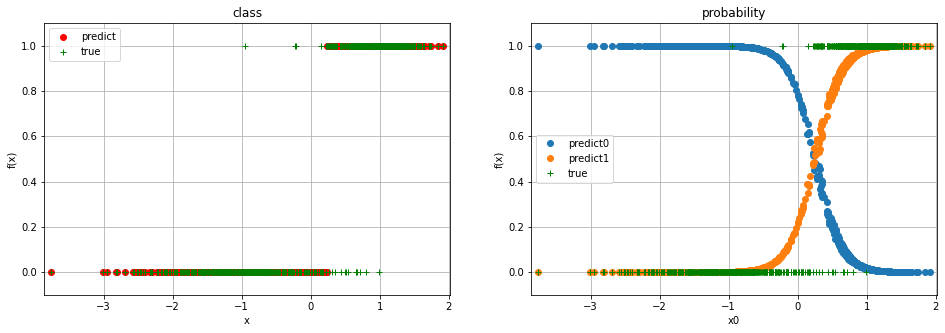

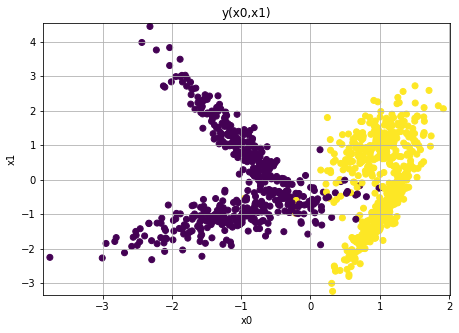

accuracy:  0.981


In [ ]:


n = 0 # номер признака для визуализации. проверить результат для n = 1
plt.figure(figsize = (16,5))

ymin = y_test_tr.min()-0.1
ymax = y_test_tr.max()+0.1
xmin = X_test_tr[:,n].min()-0.1
xmax = X_test_tr[:,n].max()+0.1

plt.subplot(1,2,1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.plot(X_test_tr[:,n], y_pred,'or', label = 'predict')
plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.title('class')

plt.subplot(1,2,2)

plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.title('probability')

for m in range(y_pred_proba.shape[1]):
  if m>1:
    mk = m
  else : mk = 1
  plt.plot(X_test_tr[:,n], y_pred_proba[:,m]*mk,'o', label = 'predict'+ str(m) )

plt.plot(X_test_tr[:,n], y_test_tr, '+g', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('x0')
plt.ylabel('f(x)')



plt.show()


plt.figure(figsize = (7.3,5))
n2 = 1
xmin0 = X_test_tr[:,n2].min()-0.1
xmax0 = X_test_tr[:,n2].max()+0.1

plt.xlabel('x0')
plt.ylabel('x1')
plt.ylim(xmin0,xmax0)
plt.xlim(xmin,xmax)
plt.scatter(X_test_tr[:,n],X_test_tr[:,n2], c = y_test_tr)
plt.title('y(x0,x1)')

plt.grid()

plt.show()


print('accuracy: ',accuracy_score(y_test_tr,y_pred))

На графиках видно, что классификация проходит не очень надежно по признаку х1 и очень хорошо по признаку х0 (практически разделяющий по значению х0 == 0, все для х0<0 соответствует метке 0, все для х0>0 м= метка 1)





  - сформируем отчет о классификации 

In [ ]:
print(classification_report(y_test_tr, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       488
           1       0.97      0.99      0.98       512

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



  - проведем эксперимент для нескольких перезапусков алгоритма (К) и различных сочетаний значений гиперпараметров (tol, max_iter). Сделаем сеточный поиск в пространстве вариантов для множества К = 10 реализаций 

In [ ]:
import seaborn as sns

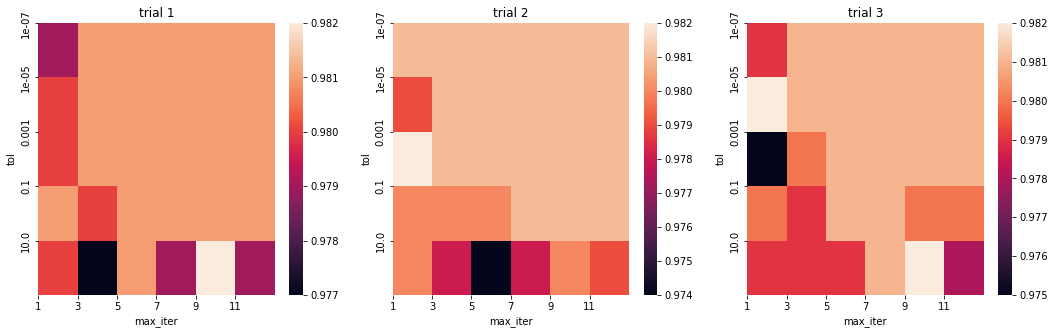

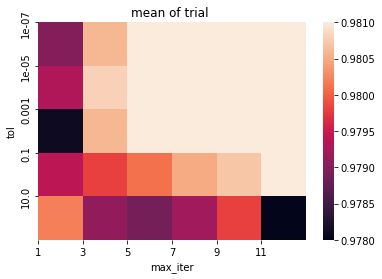

In [ ]:
# Эксперимент
rez = []
K = 10
for tol in np.logspace(-7,1,5):
  for max_iter in range(1,12,2):
    acc = []
    for k in range(K):
      logistic_regressor = LogisticRegression( tol = tol, max_iter=max_iter, solver = 'saga')
      # обучим ее
      logistic_regressor.fit(X_train_tr, y_train_tr)
      y_pred = logistic_regressor.predict(X_test_tr) 
      acc += [accuracy_score(y_test_tr,y_pred)]
    rez += [[tol,max_iter]+ acc]

rez = np.array(rez)

# Визуализация результата в форме тепловой диаграммы для отдельных реализаций
plt.figure(figsize = (18,5))
for i in [1,2,3]:
  plt.subplot(1,3,i)
  acc_all = rez[:,-i].reshape(5,6)
  sns.heatmap(acc_all)
  plt.title('trial '+str(i))
  plt.xlabel('max_iter')
  plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
  plt.ylabel('tol')
  plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()

# Визуализация результата в форме тепловой диаграммы для среднего по всем реализациям (можно еще и разбросс смотреть)

acc_mean = rez[:,-K:].mean(axis=1).reshape(5,6)
sns.heatmap(acc_mean)
plt.title('mean of trial ')
plt.xlabel('max_iter')
plt.xticks(list(range(6)),[str(x) for x in range(1,12,2)])
plt.ylabel('tol')
plt.yticks(list(range(5)),[str(x) for x in np.logspace(-7,1,5)])
plt.show()


  - вывод: необходимо более 5 итераций и менее 0.1 tol. Выборка примеров сбалансирована, и применение метрик типа accuracy обосновано

### **Задание 3.**

Построить последовательность обработки примеров для набора "Ирисы Фишера"(load_iris):
 - провести генерацию классификатора
 - провести анализ результата (см. пример)

In [ ]:
data = load_iris()
X, y = data.data, data.target
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X, y, test_size=0.2, random_state=1)

### **Задание 4.**

Самостоятельно оценить данные по варианту:

In [ ]:

V1 = datasets.load_wine()
V2 = datasets.load_digits()
V3 = datasets.load_breast_cancer()
V4 = datasets.make_classification(n_samples = 1000, n_features=10, n_redundant=2, n_informative=2,random_state=10, n_clusters_per_class=2)
V5 = datasets.make_blobs(n_samples=1000, centers=2, n_features=5, random_state=10)

 4.1.Загрузить данные  по варианту 

 4.2.Построить линейный классификатор в формате sklearn (LogisticRegression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) и в коде из Задания 1.
 
 4.3. Выбрать метрику (учитываем балансировку данных и смысл задачи) и оценить качество модели на отложенной выборке
 
 4.4. сделать выводы о качестве для модели из задания 1 и sklearn на основе выбранной метрики

 4.5. Привести все признаки к одному диапазону (0,1) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) или провести стандартизацию признаков (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) , построить модель в sklearn и оценить метрики на отложеной выборке
 
 4.6. Построить классификатор с изменением основных гиперпараметров (по sklearn) : эксперимент по каждому направлению отдельно : penalty  {'l2', 'l1'}, tol = [0.0001, 0.001, 0.01, 0.1], max_iter=[1,2,5,10, 20,50,100,500]. Зафиксировать в каждом эксперименте(при изменении одного из параметров) accuracy, f1,точность, полнота, РR_auc,  ROC_auc в таблице результатов.
 
 4.7 Повторить кадый эксперимент 5-10 раз для всех вариантов значений и построить зависимость метрики от каждого из гиперпараметров отдельно (или парами в виде тепловой диаграммы)

 4.8 Сделать выводы о качестве модели

Резюме Логистической регрессии:

  - Делает численные оценки вероятности его принадлежности каждому из классов.

  - Является частным случаем обобщённой линейной модели регрессии

  - Оценки вероятностей и рисков могут оказаться неадекватными, если не признаки зависимы
  - Практичная реализация должна предусматривать :
      - стандартизацию данных, 
      - отсев выбросов, 
      - регуляризацию,
      - отбор признаков.

Вопросы для контроля:

  1. Метод стохастического градиента. Расписать градиентный шаг для квадратичной функции потерь и для линейной регрессии.
  2. Недостатки метода SG и как с ними бороться?
  3. Обоснование логистической регрессии и ее идея.
  4. Как выражается функция потерь в логистической регрессии .
  5. Что такое ROC-кривая, как она определяется?
  6. В каких алгоритмах классификации можно узнать не только классовую принадлежность классифицируемого объекта, но и вероятность того, что данный объект принадлежит каждому из классов?
  7. Что такое принцип максимума совместного правдоподобия данных и модели?